In [1]:
WIDTH = 320
HEIGHT = 240

IMAGE_W = 1920
IMAGE_H = 1080
WINDOW_W = 928
WINDOW_H = 696

# for video_1:
# WINDOW_X = (IMAGE_W - WINDOW_W) // 2
# WINDOW_Y = 0
# HEATMAP_Y = 0

# for video_2, video_3 and video_4:
WINDOW_X = 358
WINDOW_Y = 234
HEATMAP_Y = 100

MAX_D = 101
ADDED_D = 4

ROOT_FOLDER = "D:/tensorflow-depth-estimation"

# IMAGE_PATH = f"{ROOT_FOLDER}/video_utils/videos/video_1_cut/frame_00942.jpg"
# IMAGE_PATH = f"{ROOT_FOLDER}/video_utils/videos/video_1_cut/frame_00940.jpg"
# IMAGE_PATH = f"{ROOT_FOLDER}/video_utils/videos/video_1_cut/frame_00337.jpg"
IMAGE_PATH = f"{ROOT_FOLDER}/video_utils/videos/video_2/frame_00253.jpg"

MODEL_NAME = f"{ROOT_FOLDER}/model_kitti_unet_1709064377.keras"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import cv2

In [3]:
%run utils/datasets.ipynb

In [4]:
model = tf.keras.models.load_model(MODEL_NAME, compile=False) # only for prediction

In [5]:
image = cv2.imread(IMAGE_PATH)
image2 = image[WINDOW_Y : WINDOW_Y + WINDOW_H, WINDOW_X : WINDOW_X + WINDOW_W, :]
cv2.imwrite(f"{ROOT_FOLDER}/tmp.jpg", image2)

True

In [6]:
x_test = np.empty((1, HEIGHT, WIDTH, 3))
x_test[0, ] = preprocess_image(f"{ROOT_FOLDER}/tmp.jpg", HEIGHT, WIDTH, depth=False, horizontal_flip=False)

1/1 [==============================] - 6s 6s/step


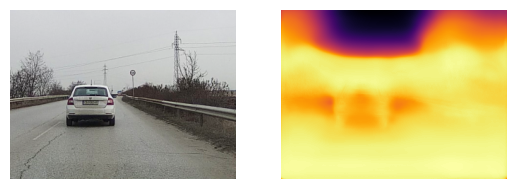

In [7]:
prediction = model.predict(x_test, batch_size=1)

prediction = prediction[0]

prediction = ADDED_D + prediction * MAX_D

plt.subplot(1, 2, 1)
plt.axis("off")
img1 = preprocess_image(f"{ROOT_FOLDER}/tmp.jpg", HEIGHT, WIDTH, depth=False, horizontal_flip=False)
img1 = cv2.cvtColor((img1 * 255).astype(np.uint8), cv2.COLOR_BGR2RGB)
plt.imshow(img1)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.imshow(prediction, cmap=plt.get_cmap('inferno_r'))

plt.show()

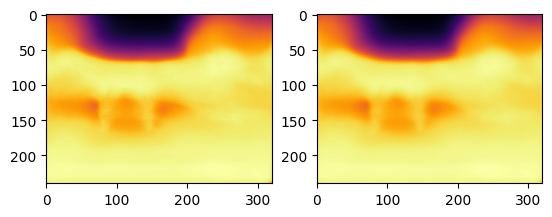

In [8]:
plt.subplot(1, 2, 1)
plt.imshow(prediction, cmap=plt.get_cmap('inferno_r'))
plt.subplot(1, 2, 2)
smoothed = cv2.GaussianBlur(prediction, (11, 11), 0)
plt.imshow(smoothed, cmap=plt.get_cmap('inferno_r'))

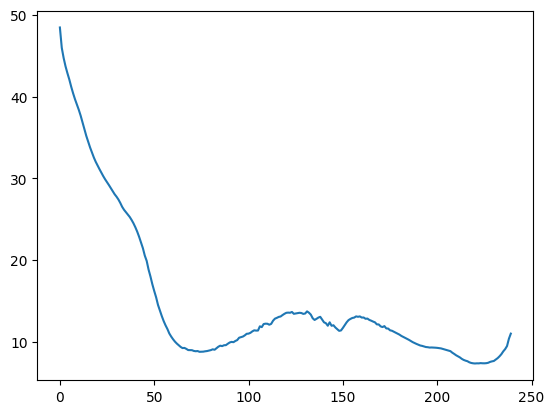

In [9]:
plt.plot(np.arange(HEIGHT), prediction[:,250])

35
(240, 320)
72986
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(240, 320)
(165, 91, 12, 4)


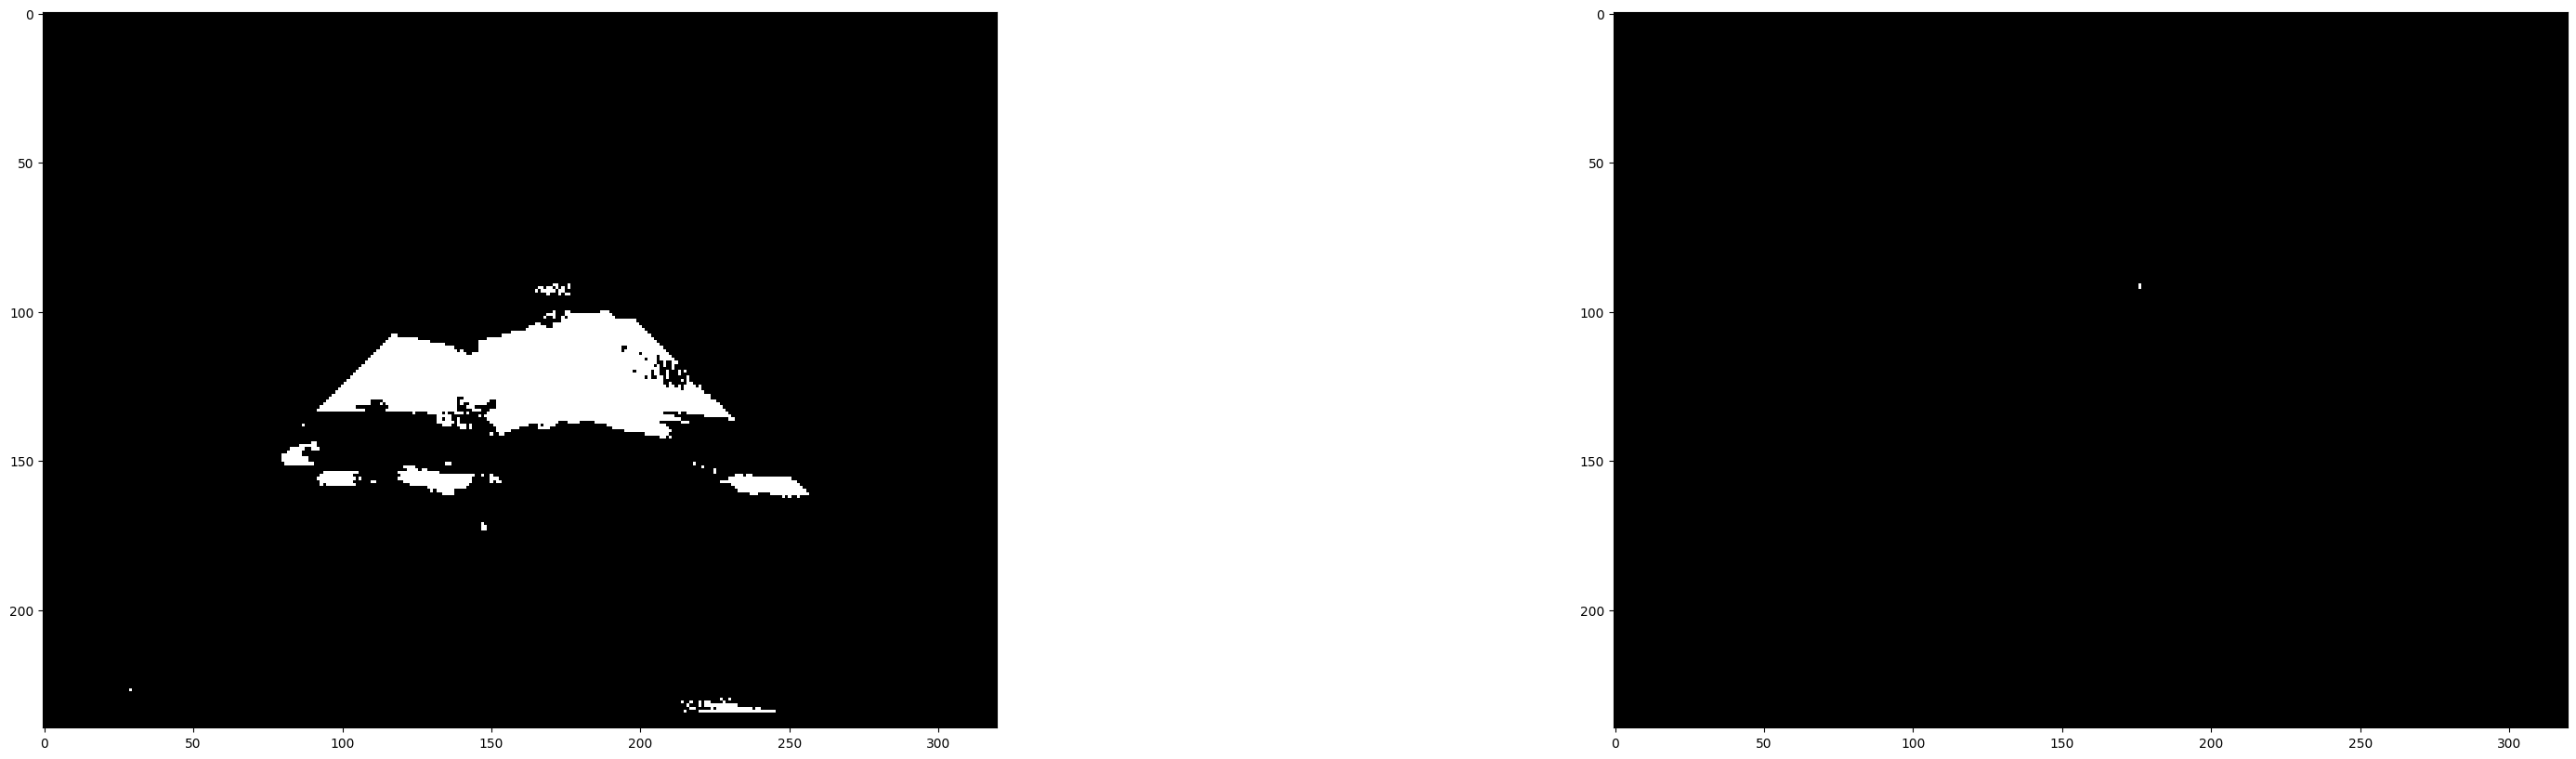

In [10]:
depth = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)

for h in range(80, 230):
    # median = np.median(smoothed[h, :])
    for w in range(5, 315):
        if h < 220 and (w / (h - 220) > -1 or (WIDTH - w) / (h - 220) > -1):
            continue
        #print(abs(smoothed[h, w] - median), 0.2 * median)
        #if 0.4 * median > abs(smoothed[h, w] - median) > 0.3 * median:
        if prediction[h, w] > 1.03 * np.mean(prediction[h - 5 : h - 1, w]):
            depth[h + 5, w] = 255
        #break

# depth2 = cv2.morphologyEx(depth, cv2.MORPH_CLOSE, np.ones((1, 40)))
# depth = cv2.morphologyEx(depth, cv2.MORPH_HITMISS, np.ones((4, 20)))
# depth2 = cv2.morphologyEx(depth2, cv2.MORPH_HITMISS, np.ones((4, 4)))

ret1, lab = cv2.connectedComponents(depth)
print(ret1)
print(lab.shape)
print(len(lab[lab == 0]))
print(lab[lab == 1])
print((lab == 0).shape)

mask = np.zeros((HEIGHT, WIDTH), np.uint8)
mask[lab == 1] = 255
data = cv2.bitwise_and(depth, depth, mask=mask)

ret = cv2.boundingRect(data)
print(ret)

plt.figure(figsize=(40,10))
plt.subplot(1, 2, 1)
plt.imshow(depth, 'gray')
plt.subplot(1, 2, 2)
plt.imshow((lab == 2), 'gray')

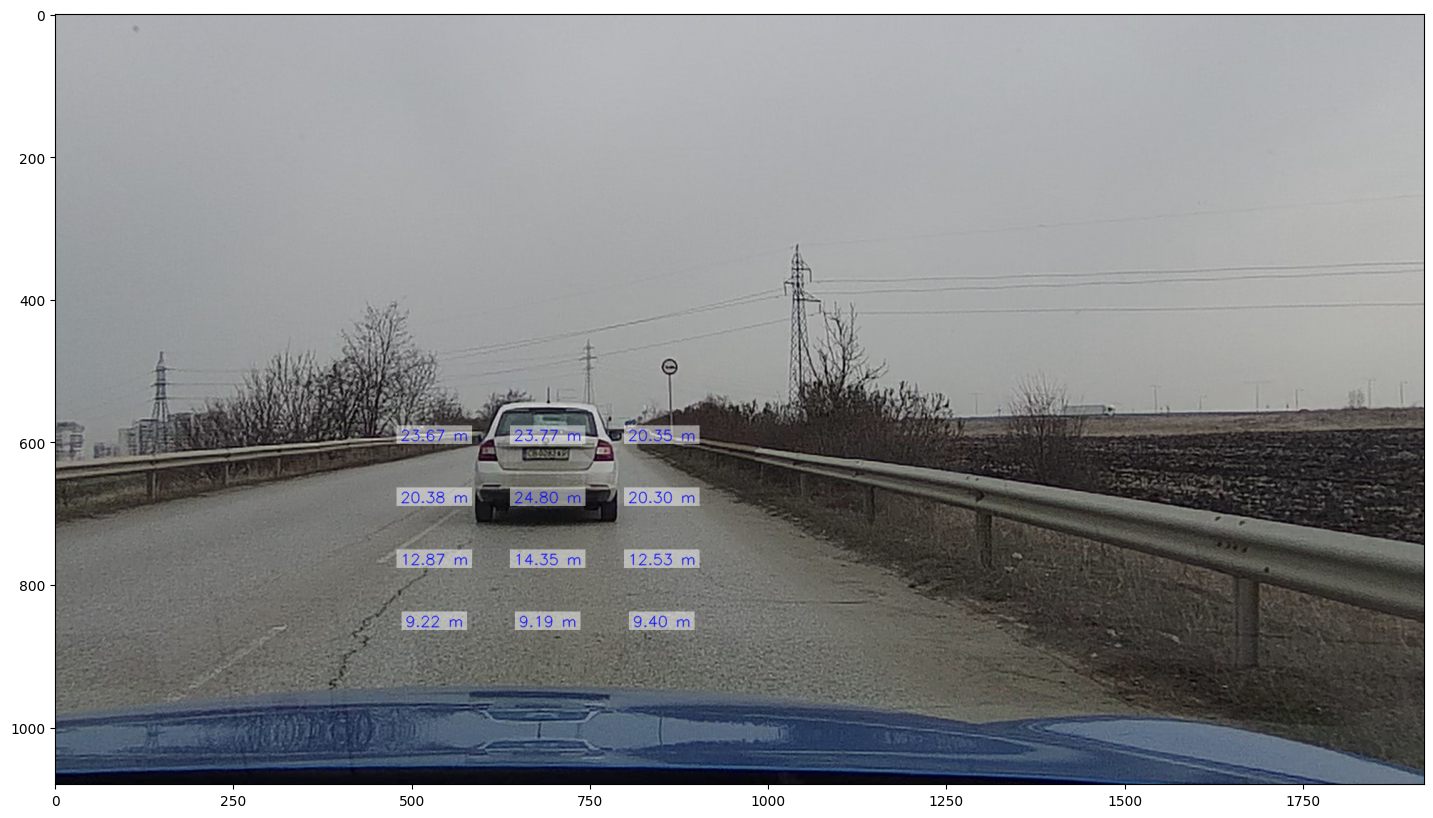

In [11]:
depth3 = image.copy()

font = cv2.FONT_HERSHEY_SIMPLEX 
font_scale = 0.7
color = (255, 0, 0)
thickness = 1

# points = depth.copy().astype(np.uint8)

points = np.zeros((HEIGHT, WIDTH), dtype=np.uint8)
points[HEIGHT // 2     , WIDTH // 2 - 100] = 255
points[HEIGHT // 2     , WIDTH // 2 - 45 ] = 255
points[HEIGHT // 2     , WIDTH // 2 + 10 ] = 255
points[HEIGHT // 2 + 30, WIDTH // 2 - 100] = 255
points[HEIGHT // 2 + 30, WIDTH // 2 - 45 ] = 255
points[HEIGHT // 2 + 30, WIDTH // 2 + 10 ] = 255
points[HEIGHT // 2 + 60, WIDTH // 2 - 100] = 255
points[HEIGHT // 2 + 60, WIDTH // 2 - 45 ] = 255
points[HEIGHT // 2 + 60, WIDTH // 2 + 10 ] = 255
points[HEIGHT // 2 + 90, WIDTH // 2 - 100] = 255
points[HEIGHT // 2 + 90, WIDTH // 2 - 45 ] = 255
points[HEIGHT // 2 + 90, WIDTH // 2 + 10 ] = 255

for h in range(220, 80, -1):
    for w in range(WIDTH):
        if points[h, w] > 128:
            dist = prediction[h, w, 0]
            text = f"{dist:.2f} m"
            text_size, _ = cv2.getTextSize(text, font, font_scale, thickness)
            text_pos = (int(WINDOW_X + WINDOW_H / HEIGHT * w - text_size[0] / 2),
                        int(WINDOW_Y + WINDOW_H / HEIGHT * h))
            rectangle = np.ones((text_size[1] + 10, text_size[0] + 10, 3), np.uint8) * 255
            alpha = 0.5
            try:
                depth3[text_pos[1] - 5 : text_pos[1] + text_size[1] + 5, text_pos[0] - 5 : text_pos[0] + text_size[0] + 5] = \
                    cv2.addWeighted(depth3[text_pos[1] - 5 : text_pos[1] + text_size[1] + 5, text_pos[0] - 5 : text_pos[0] + text_size[0] + 5], alpha, rectangle, 1 - alpha, 0)
                depth3 = cv2.putText(depth3, text,
                                     (text_pos[0], text_pos[1] + text_size[1]), font,
                                     font_scale, color, thickness, cv2.LINE_AA)
                t_w = int(HEIGHT / WINDOW_H * text_size[0])
                t_h = int(HEIGHT / WINDOW_H * text_size[1])
                find[h - t_h - 1 : h + 1, w - t_w - 1: w + t_w + 2] = 0
            except:
                pass

plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(depth3, cv2.COLOR_BGR2RGB), 'gray')

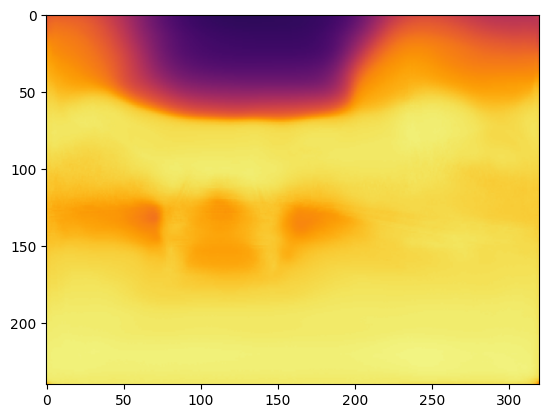

In [12]:
heatmap = cv2.applyColorMap((255 - (prediction - ADDED_D) / MAX_D * 255).astype(np.uint8), cv2.COLORMAP_INFERNO)

plt.imshow(cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB))

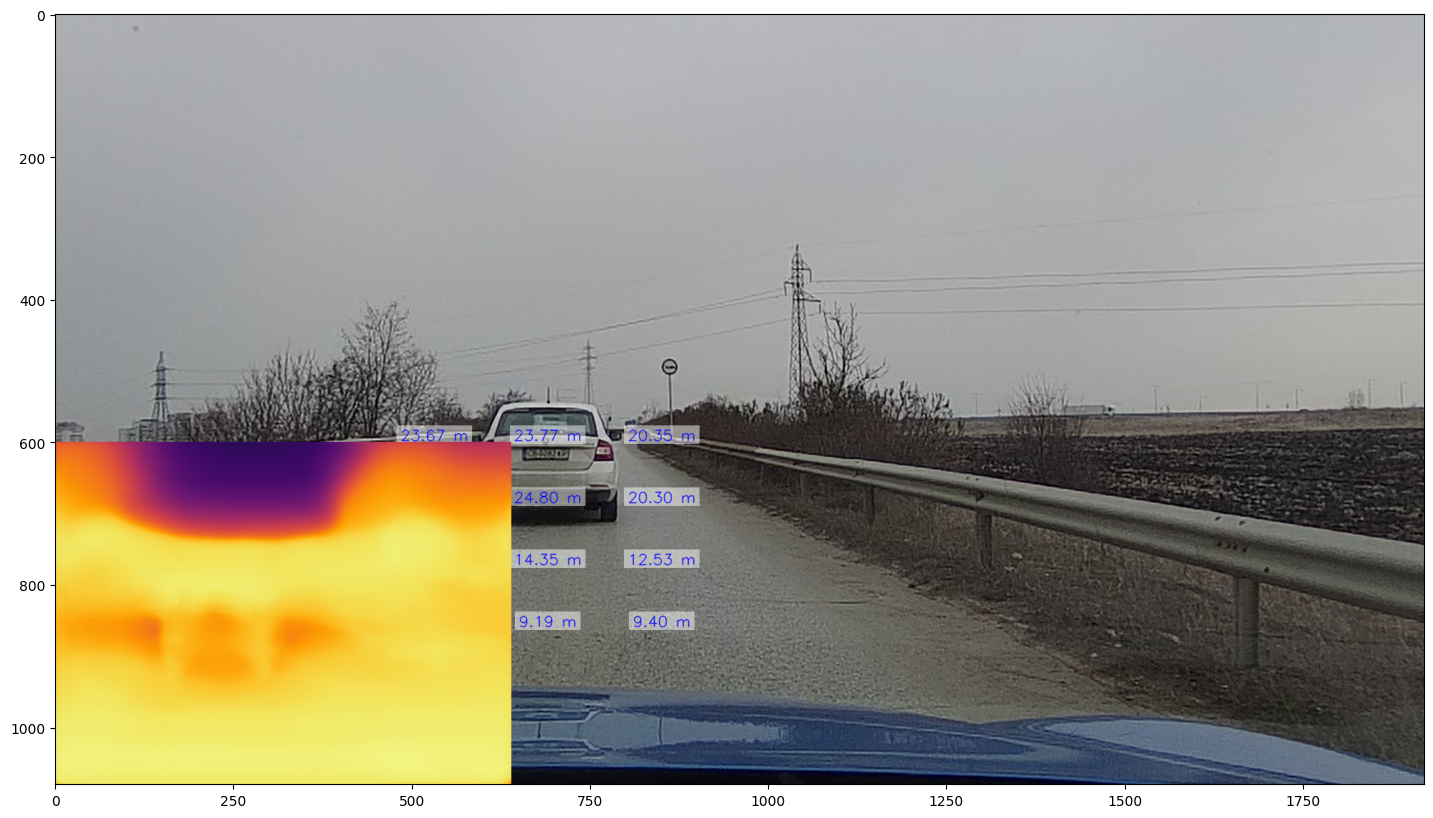

In [13]:
frame_new = depth3.copy()

heatmap2 = cv2.resize(heatmap, (2 * WIDTH, 2 * HEIGHT))

frame_new[frame_new.shape[0] - HEIGHT * 2 :, : WIDTH * 2] = heatmap2

plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(frame_new, cv2.COLOR_BGR2RGB))

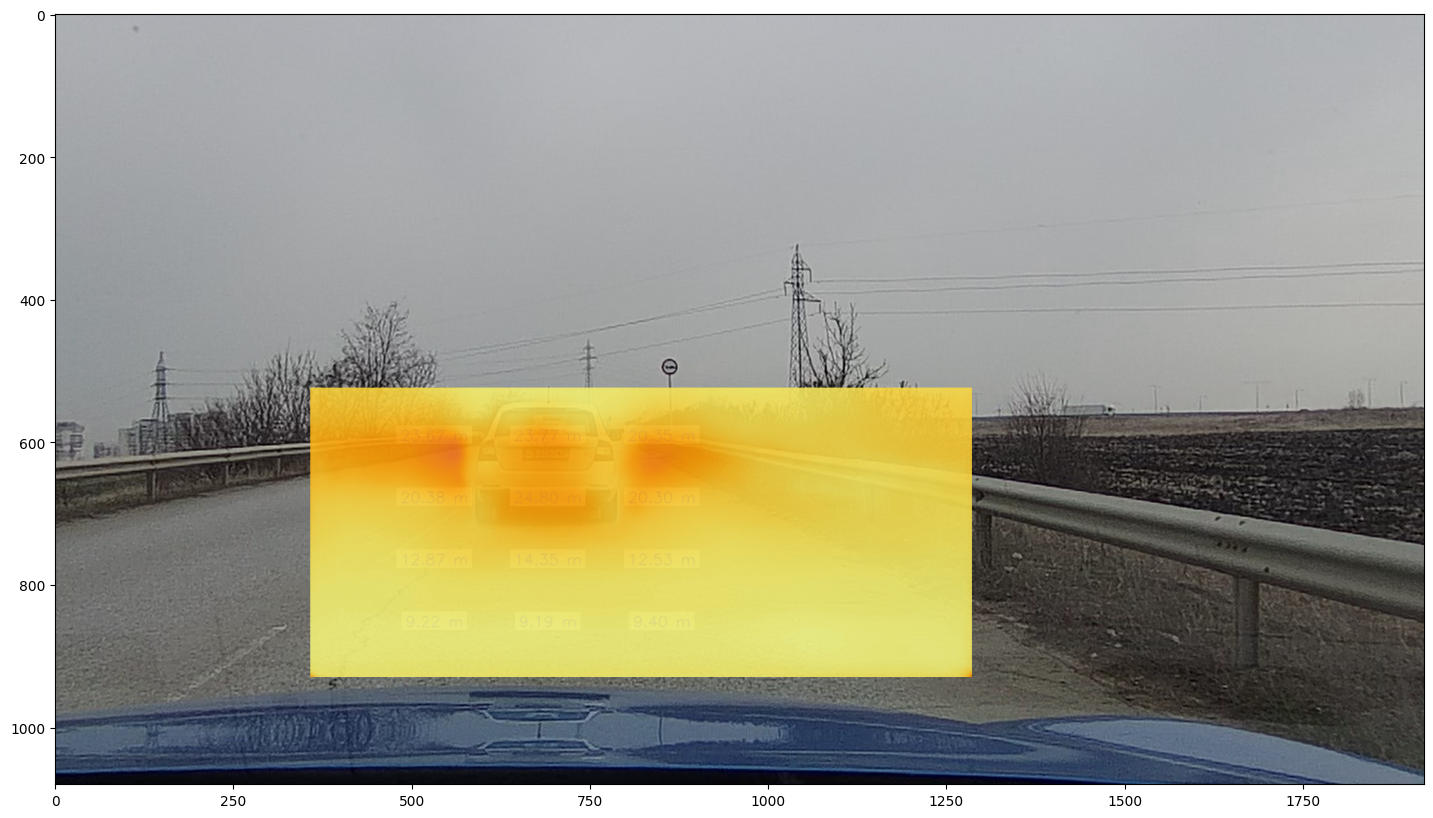

In [14]:
frame_new = depth3.copy()

heatmap2 = cv2.resize(heatmap, (WINDOW_W, WINDOW_H))
alpha = 0.1
frame_new[int(WINDOW_Y + HEATMAP_Y / HEIGHT * WINDOW_H) : WINDOW_Y + WINDOW_H,
          WINDOW_X : WINDOW_X + WINDOW_W] = \
    cv2.addWeighted(frame_new[int(WINDOW_Y + HEATMAP_Y / HEIGHT * WINDOW_H) : WINDOW_Y + WINDOW_H,
                              WINDOW_X : WINDOW_X + WINDOW_W],
                    alpha, heatmap2[int(HEATMAP_Y / HEIGHT * WINDOW_H) :, :], 1 - alpha, 0)
plt.figure(figsize=(40,10))
plt.imshow(cv2.cvtColor(frame_new, cv2.COLOR_BGR2RGB))